In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tensorflow import keras

In [2]:
img_folder = "imgs/"
team_colors = {
    "ARI": "#9B2743",
    "ATL": "#A6192E",
    "BAL": "#24125F",
    "BUF": "#003087",
    "CAR": "#0085CA",
    "CHI": "#091F2C",
    "CIN": "#DC4405",
    "CLE": "#321C00",
    "DAL": "#0C2340",
    "DEN": "#FC4C02",
    "DET": "#0069B1",
    "GB": "#183029",
    "HOU": "#091F2C",
    "IND": "#003A70",
    "JAX": "#006271",
    "KC": "#C8102E",
    "LA": "#1E22AA",
    "LAC": "#0072CE",
    "LV": "#010101",
    "MIA": "#008C95",
    "MIN": "#582C83",
    "NE": "#0C2340",
    "NO": "#D3BC8D",
    "NYG": "#001E62",
    "NYJ": "#115740",
    "PHI": "#004851",
    "PIT": "#FFB81C",
    "SEA": "#0C2340",
    "SF": "#A6192E",
    "TB": "#A6192E",
    "TEN": "#0C2340",
    "WAS": "#651C32",
}
sns.set_theme()

In [3]:
PBP_DF = pd.read_csv("data/play_by_play_1999-2022.csv")

model = keras.models.load_model("models/5-TTT-11.h5")

In [4]:
def prepare_test_data(df):
    NORM_COLUMNS = [
        'drive',
        'play_in_drive',
        'qtr',
        'quarter_seconds_remaining',
        'down',
        'ydstogo',
        'yardline_100',
        'season'
    ]
    STAN_COLUMNS = [
        'score_differential',
        'spread_line'
    ]

    # Drop coach and team
    df = df.drop(["coach", "posteam"], axis=1)

    # Normalize and Standardize data
    scaler = MinMaxScaler()
    for column in NORM_COLUMNS:
        if column in df.columns:
            df[column] = scaler.fit_transform(df[[column]])
    scaler = StandardScaler()
    for column in STAN_COLUMNS:
        if column in df.columns:
            df[column] = scaler.fit_transform(df[[column]])

    df["play_type"] = df["play_type"].map({"run": 0, "pass": 1})
    X = df.drop('play_type', axis=1).to_numpy()
    y = df['play_type'].values
    return (X, y)

In [5]:
df22 = PBP_DF[PBP_DF['season'] == 2022]
team_plays = df22.groupby('posteam')
results = []
for team, df in team_plays:
    X, y = prepare_test_data(df)
    metrics = model.evaluate(X, y)
    results.append([team, metrics[0], metrics[1]])

36/36 [==============================] - 0s 1ms/step - loss: 0.6446 - accuracy: 0.6197


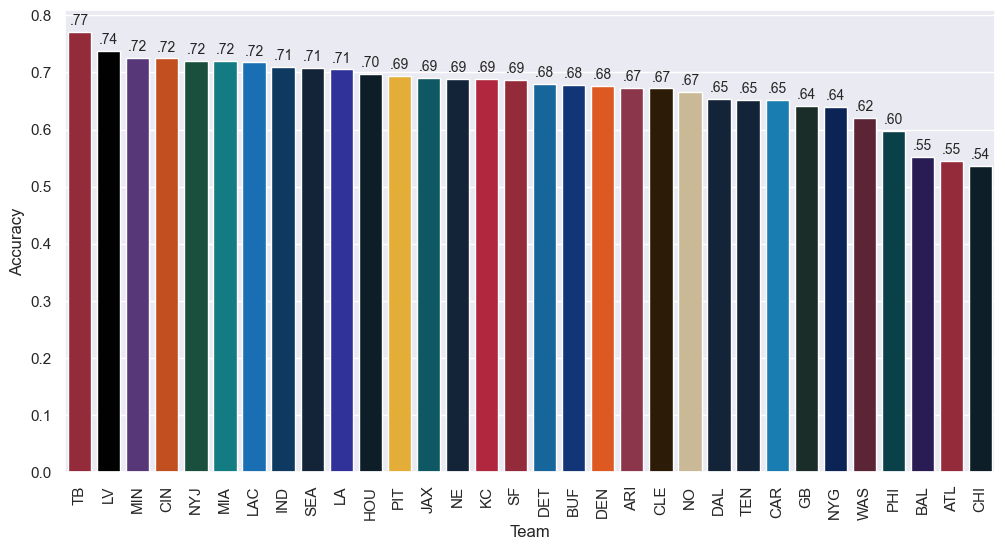

In [6]:
result_df = pd.DataFrame(results, columns=["Team", "Loss", "Accuracy"])
result_df = result_df.sort_values('Accuracy', ascending=False)

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=result_df, x="Team", y="Accuracy", palette=team_colors, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Iterate over the bars and put the accuracy value with 2 decimals on top of each bar
for i, bar in enumerate(ax.containers[0].patches):
    bar_height = bar.get_height()
    ax.annotate(f".{(100 * result_df.iloc[i]['Accuracy']).round():.2g}", xy=(bar.get_x() + bar.get_width() / 2, bar_height), xytext=(0, 3), 
                textcoords="offset points", ha='center', va='bottom', fontsize=10)

plt.show()

In [7]:
df22["Pass Percentage"] = df22["play_type"].map({"run": 0, "pass": 1})
grouped = df22.groupby("posteam")["Pass Percentage"].mean().reset_index()

merged = pd.merge(result_df, grouped, left_on="Team", right_on="posteam", how="left")
merged["Wins"]=[
    8, 6, 13, 12, 7, 9, 10, 4, 9, 5, 3, 9, 9, 8, 14, 13, 9, 13, 5, 4, 7, 7, 12, 7, 7, 8, 9, 8, 14, 10, 7, 3
]
merged.head()

,Team,Loss,Accuracy,posteam,Pass Percentage,Wins
0,TB,0.459196,0.770304,TB,0.687449,8
1,LV,0.520631,0.737548,LV,0.594828,6
2,MIN,0.520079,0.724700,MIN,0.648370,13
3,CIN,0.550299,0.724422,CIN,0.636139,12
4,NYJ,0.544840,0.720602,NYJ,0.629351,7


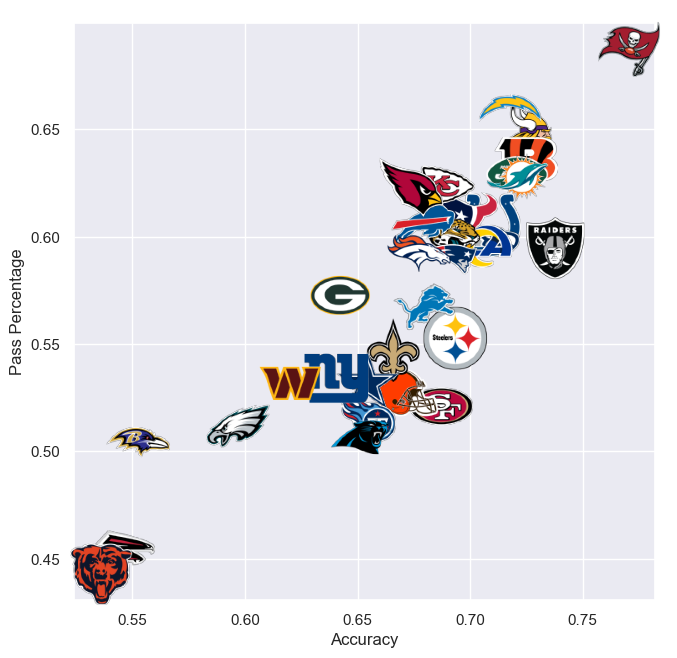

In [8]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))

# Define a function to load the images and resize them
def read_and_resize(filename):
    img = plt.imread(filename)
    return OffsetImage(img, zoom=0.6)

# Iterate over the rows of the dataframe
for index, row in merged.iterrows():
    # Get the team abbreviation and the corresponding filename
    team = row["Team"]
    filename = os.path.join(img_folder, f"{team}.png")
    
    # Create the annotation box for the image
    ab = AnnotationBbox(
        read_and_resize(filename),
        (row["Accuracy"], row["Pass Percentage"]),
        xybox=(0, 0),
        frameon=False,
        xycoords='data',
        boxcoords="offset points"
    )
    
    # Add the annotation box to the plot
    ax.add_artist(ab)

# Create the scatter plot
sns.set(font_scale=1.4)
sns.scatterplot(
    data=merged,
    x="Accuracy",
    y="Pass Percentage",
    hue="Team",
    palette=team_colors,
    s=0,
    legend=False,
    ax=ax,
)

plt.show()

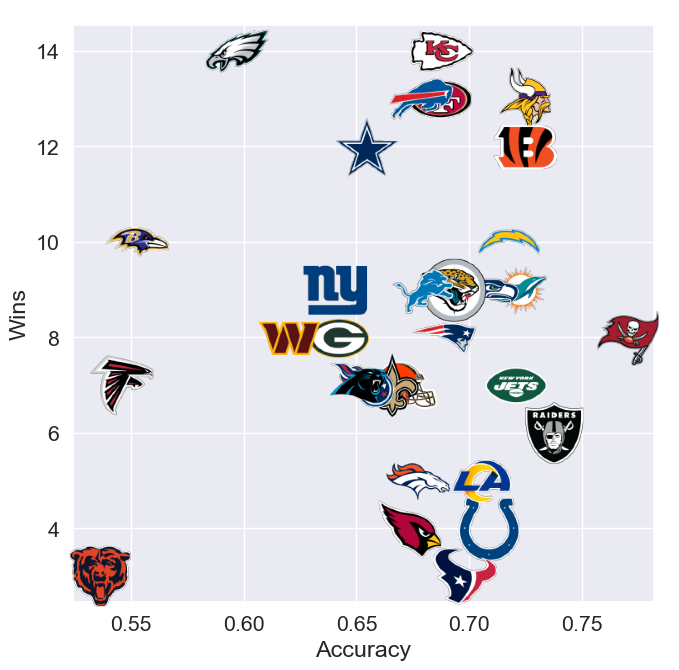

In [9]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))

# Define a function to load the images and resize them
def read_and_resize(filename):
    img = plt.imread(filename)
    return OffsetImage(img, zoom=0.6)

# Iterate over the rows of the dataframe
for index, row in merged.iterrows():
    # Get the team abbreviation and the corresponding filename
    team = row["Team"]
    filename = os.path.join(img_folder, f"{team}.png")
    
    # Create the annotation box for the image
    ab = AnnotationBbox(
        read_and_resize(filename),
        (row["Accuracy"], row["Wins"]),
        xybox=(0, 0),
        frameon=False,
        xycoords='data',
        boxcoords="offset points"
    )
    
    # Add the annotation box to the plot
    ax.add_artist(ab)

# Create the scatter plot
sns.set(font_scale=1.2)
sns.scatterplot(
    data=merged,
    x="Accuracy",
    y="Wins",
    hue="Team",
    palette=team_colors,
    s=0,
    legend=False,
    ax=ax,
)

plt.show()

In [10]:
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

with open("random_forest.model", "rb") as pickle_in:
    model = pickle.load(pickle_in)

df22 = PBP_DF[PBP_DF['season'] == 2022]
team_plays = df22.groupby('posteam')
results = []
for team, df in team_plays:
    X, y = prepare_test_data(df)
    accuracy = accuracy_score(model.predict(X), y)
    results.append([team, accuracy])
result_df = pd.DataFrame(results, columns=["Team", "Accuracy"])

new_merged = pd.merge(result_df, merged, on="Team", how="left")

In [18]:
# new_merged.drop("Accuracy_y", axis=1, inplace=True)
new_merged = new_merged.rename(columns={"Accuracy_x": "Accuracy"})
new_merged.head()

,Team,Accuracy,Loss,posteam,Pass Percentage,Wins
0,ARI,0.660194,0.643486,ARI,0.623124,4
1,ATL,0.522568,0.793024,ATL,0.449348,7
2,BAL,0.536563,0.800851,BAL,0.504570,10
3,BUF,0.662892,0.630481,BUF,0.605401,13
4,CAR,0.619442,0.645506,CAR,0.506722,7


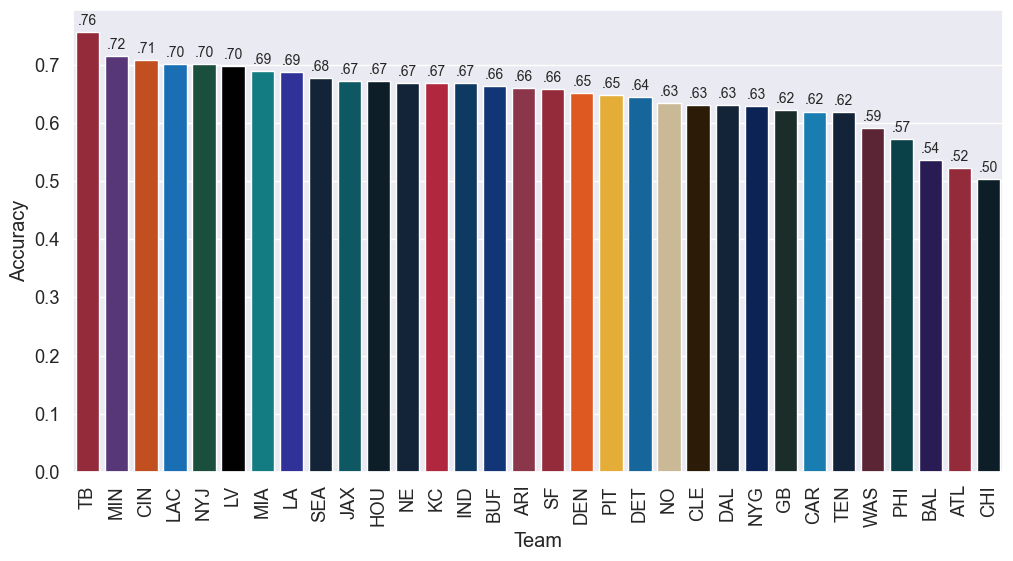

In [20]:
new_merged = new_merged.sort_values('Accuracy', ascending=False)

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=new_merged, x="Team", y="Accuracy", palette=team_colors, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Iterate over the bars and put the accuracy value with 2 decimals on top of each bar
for i, bar in enumerate(ax.containers[0].patches):
    bar_height = bar.get_height()
    ax.annotate(f".{(100 * new_merged.iloc[i]['Accuracy']).round():.2g}", xy=(bar.get_x() + bar.get_width() / 2, bar_height), xytext=(0, 3), 
                textcoords="offset points", ha='center', va='bottom', fontsize=10)

plt.show()

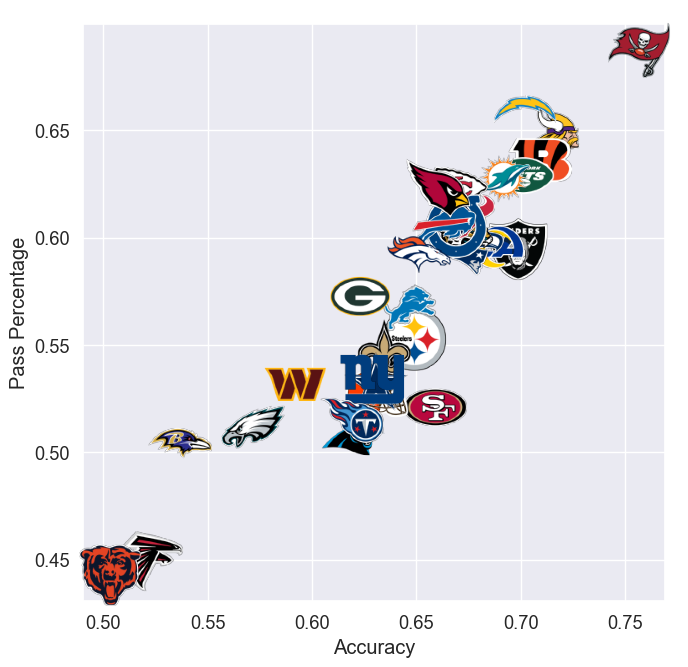

In [21]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))

# Define a function to load the images and resize them
def read_and_resize(filename):
    img = plt.imread(filename)
    return OffsetImage(img, zoom=0.6)

# Iterate over the rows of the dataframe
for index, row in new_merged.iterrows():
    # Get the team abbreviation and the corresponding filename
    team = row["Team"]
    filename = os.path.join(img_folder, f"{team}.png")
    
    # Create the annotation box for the image
    ab = AnnotationBbox(
        read_and_resize(filename),
        (row["Accuracy"], row["Pass Percentage"]),
        xybox=(0, 0),
        frameon=False,
        xycoords='data',
        boxcoords="offset points"
    )
    
    # Add the annotation box to the plot
    ax.add_artist(ab)

# Create the scatter plot
sns.set(font_scale=1.4)
sns.scatterplot(
    data=new_merged,
    x="Accuracy",
    y="Pass Percentage",
    hue="Team",
    palette=team_colors,
    s=0,
    legend=False,
    ax=ax,
)

plt.show()

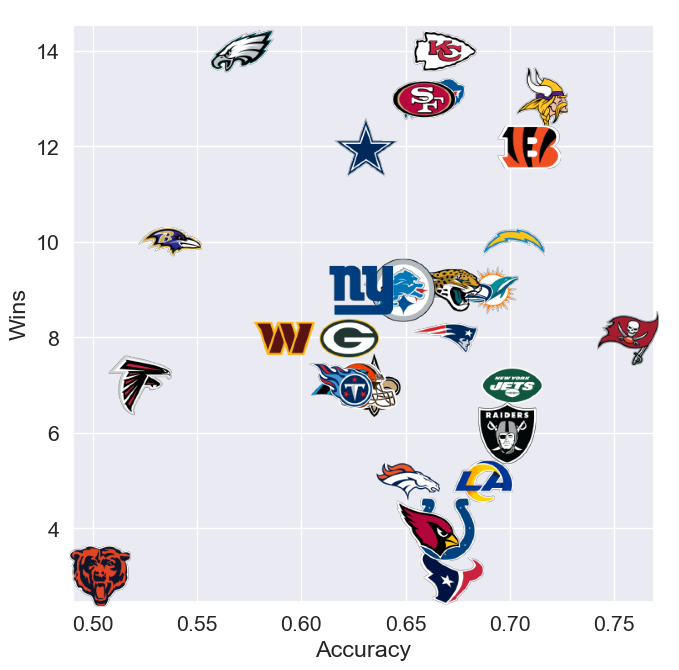

In [22]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))

# Define a function to load the images and resize them
def read_and_resize(filename):
    img = plt.imread(filename)
    return OffsetImage(img, zoom=0.6)

# Iterate over the rows of the dataframe
for index, row in new_merged.iterrows():
    # Get the team abbreviation and the corresponding filename
    team = row["Team"]
    filename = os.path.join(img_folder, f"{team}.png")
    
    # Create the annotation box for the image
    ab = AnnotationBbox(
        read_and_resize(filename),
        (row["Accuracy"], row["Wins"]),
        xybox=(0, 0),
        frameon=False,
        xycoords='data',
        boxcoords="offset points"
    )
    
    # Add the annotation box to the plot
    ax.add_artist(ab)

# Create the scatter plot
sns.set(font_scale=1.2)
sns.scatterplot(
    data=new_merged,
    x="Accuracy",
    y="Wins",
    hue="Team",
    palette=team_colors,
    s=0,
    legend=False,
    ax=ax,
)

plt.show()